In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import glob
import os
from argparse import ArgumentParser
from PIL import Image
from torchvision.transforms import functional as F
from tqdm import tqdm
from utilities.print_utils import *
from transforms.classification.data_transforms import MEAN, STD
from utilities.utils import model_parameters, compute_flops

from fastai import *
from fastai.vision import *
from fastai.torch_core import *

In [2]:
import importlib
import jn_utils_segmentation 
importlib.reload(jn_utils_segmentation)

import importlib
import jn_train_segmentation 
importlib.reload(jn_train_segmentation)

<module 'jn_train_segmentation' from '/home/john/github/EdgeNets/jn_train_segmentation.py'>

In [4]:
# in_args = "--model espnetv2 --s 2.0 --dataset city --data-path /home/john/github/data/cityscapes/ --split val --im-size 1024 512"
# 
# args = jn_test_segment.load_args(in_args)
# in_args = " --dir /home/john/github/EdgeNets/ \
#             --model espnetv2 --s 2.0  \
#             --dataset city  \
#             --data-path /home/john/github/data/FEC-crop-half/  \
#             --split val  \
#             --im-size 1024 512 \
#             --num-classes 20 \
#         "
#           # --weights-test /home/john/github/EdgeNets/model/segmentation/model_zoo/espnetv2/espnetv2_s_2.0_city_1024x512.pth \
#           # "
# 
# args = jn_utils_segmentation.load_args(in_args)
# model, device = jn_utils_segmentation.load_model(args)

2019-09-09 16:51:15 - WARNING - Training from scratch!!
2019-09-09 16:51:15 - INFO    - Loading model weights
2019-09-09 16:51:15 - INFO    - Weight loaded successfully


In [3]:
in_args = " --model dicenet --s 1.0  \
            --data-path /home/john/github/data/FEC-crop-half/  \
            --num-classes 3 \
        "

in_args = " --model shufflenetv2 --s 0.5  \
            --data-path ./vision_datasets/cityscapes/  \
            --num-classes 3 \
         "

args = jn_train_segmentation.load_args(in_args)
model = jn_train_segmentation.load_model(args)

# in_args = " \
#             --model dicenet --s 1.0  \
#             --dataset city  \
#             --data-path /home/john/github/data/FEC-crop-half/  \
#             --num-classes 20 \
#         "
#           # --weights-test /home/john/github/EdgeNets/model/segmentation/model_zoo/espnetv2/espnetv2_s_2.0_city_1024x512.pth \
#           # "
# 
# args = jn_train_segmentation.load_args(in_args)
# model, device = jn_train_segmentation.load_model(args)

2019-09-10 09:35:09 - LOGS    - Loading pretrained basenet model weights
2019-09-10 09:35:09 - LOGS    - 62.33 % of weights copied from basenet to segnet
2019-09-10 09:35:09 - LOGS    - Pretrained basenet model loaded!!


In [4]:
m = list(model.modules())
len(m)

409

In [7]:
m = list(model.parameters(recurse=True))
len(m)

346

In [42]:
m = list(model.named_parameters())
len(m)

325

In [41]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        

base_net.level1.conv.weight tensor([[[[ 7.5395e-03,  2.4577e-01, -1.1508e-01],
          [-3.2039e-01, -4.2936e-02,  2.2415e-01],
          [ 5.7607e-02, -3.3248e-01,  4.9884e-02]],

         [[ 5.3546e-03,  3.6634e-01, -2.2451e-01],
          [-4.2729e-01,  8.2033e-03,  3.6376e-01],
          [ 1.9157e-01, -3.7818e-01,  1.2473e-01]],

         [[-5.5300e-03,  1.9824e-01, -5.8125e-02],
          [-3.1309e-01, -7.2910e-02,  6.9259e-02],
          [-9.2021e-02, -2.6875e-01, -1.0280e-02]]],


        [[[ 8.6897e-04, -2.9358e-02,  1.0627e-01],
          [ 3.5837e-02, -2.5952e-01, -2.9368e-01],
          [ 4.0405e-02,  2.2096e-01,  1.1367e-01]],

         [[ 6.2870e-02,  6.1907e-02,  2.6301e-01],
          [-7.4754e-02, -4.6458e-01, -4.5040e-01],
          [-5.8398e-02,  2.1970e-01,  2.9052e-02]],

         [[-2.0094e-02, -7.7572e-02,  2.4043e-02],
          [-4.6131e-02, -2.3544e-01, -2.6588e-01],
          [ 5.0456e-02,  1.3204e-01,  7.7498e-02]]],


        [[[-8.8390e-02, -2.1100e-01, -

In [ ]:
jn_utils_segmentation.unfreeze_base(model)

In [30]:
jn_utils_segmentation.freeze_base(model)

Parameters unfrozen = 102, Parameters frozen = 223 


In [5]:
num_gpus = torch.cuda.device_count()
device = 'cuda' if num_gpus > 0 else 'cpu'
from torchsummary import summary
summary(model, (3, 512, 512),  device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 256, 256]             648
       BatchNorm2d-2         [-1, 24, 256, 256]              48
             PReLU-3         [-1, 24, 256, 256]              24
               CBR-4         [-1, 24, 256, 256]               0
         MaxPool2d-5         [-1, 24, 128, 128]               0
            Conv2d-6           [-1, 24, 64, 64]             216
       BatchNorm2d-7           [-1, 24, 64, 64]              48
                CB-8           [-1, 24, 64, 64]               0
            Conv2d-9           [-1, 24, 64, 64]             576
      BatchNorm2d-10           [-1, 24, 64, 64]              48
            PReLU-11           [-1, 24, 64, 64]              24
              CBR-12           [-1, 24, 64, 64]               0
        DWSepConv-13           [-1, 24, 64, 64]               0
           Conv2d-14         [-1, 24, 1

In [6]:
torch.cuda.is_available()
device

'cuda'

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.devic("cpu")
defaults.device = device
print(device)

# get_label_fn = lambda x: path_lbl/f'{x.stem}.png'

def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax


cuda:0


In [7]:
# create data set

path_img = Path('/home/john/github/data/FEC-crop-half/images-200-subset')
path_lbl = Path('/home/john/github/data/FEC-crop-half/labels-200')

codes = np.array(['background', 'egg1', 'egg2']);codes

get_label_fn = lambda x: path_lbl/f'{x.stem}.png'

src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.2, seed=42)
       .label_from_func(get_label_fn, classes=codes, convert_mode='RGB'))
# tfms = get_transforms(flip_vert=True, max_rotate=5., max_zoom=1., max_warp=0.)
size = 224

bs = 20
data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


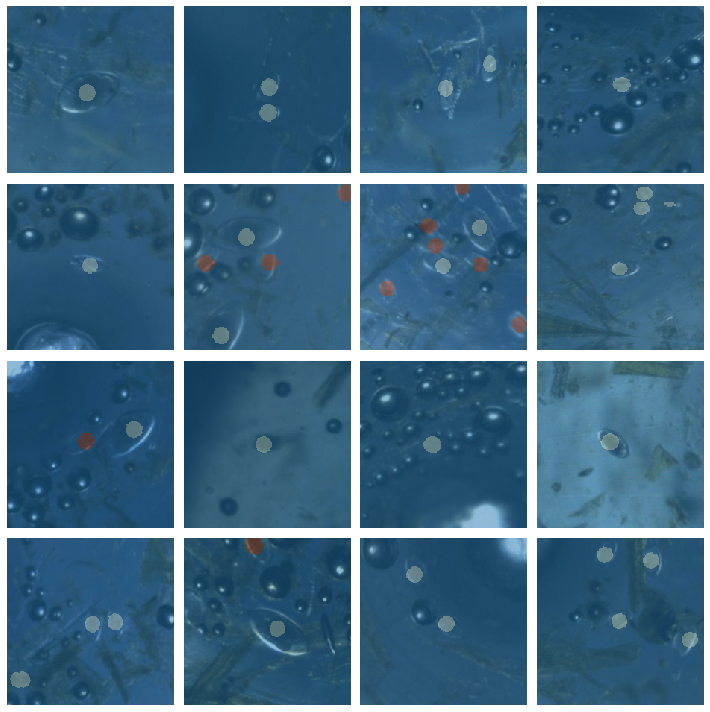

In [17]:
data.show_batch(4, figsize=(10,10))

In [8]:
#
def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
  
metrics=[acc_metric1, acc_metric2]
## uses torch.nn.CrossEntropyLoss(...)    as a super class  
class myLoss2(nn.CrossEntropyLoss):    
    def __init__(self, weight=None):
        super(myLoss2, self).__init__()

    def forward(self, input, target):
        target = target.squeeze()
        ret = super(myLoss2, self).forward(input, target)
        return ret
    
weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # weight forground at 1/10
class_weights = torch.FloatTensor(weights)       

loss_func = myLoss2(weight=class_weights) 

learn = Learner(data, model, loss_func = loss_func, metrics = metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


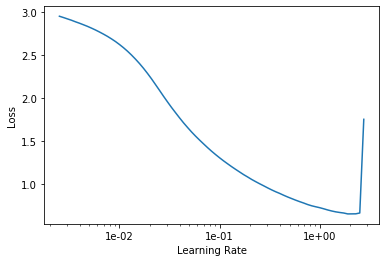

In [9]:
learn.lr_find(start_lr=1e-3)

learn.recorder.plot()

In [11]:
lr=1e-2
learn.fit_one_cycle(3, slice(lr), pct_start=0.5)

epoch,train_loss,valid_loss,acc_metric1,acc_metric2,time
0,0.508667,0.286608,0.976361,0.000000,00:21
1,0.239121,0.086066,0.977744,0.091262,00:21
2,0.140780,0.072469,0.979907,0.424708,00:21


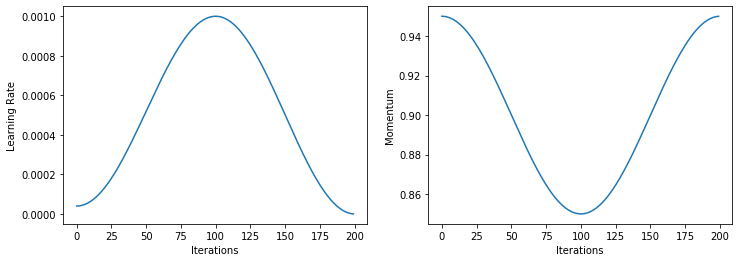

In [43]:
learn.recorder.plot_lr(show_moms=True)

In [12]:
lr=3e-3
learn.fit_one_cycle(5, slice(lr), pct_start=0.5)

epoch,train_loss,valid_loss,acc_metric1,acc_metric2,time
0,0.072020,0.069911,0.980732,0.318333,00:21
1,0.069931,0.064884,0.981697,0.398168,00:21
2,0.066380,0.058144,0.982048,0.428855,00:21
3,0.062157,0.055653,0.983012,0.414382,00:21
4,0.057914,0.053061,0.983420,0.549073,00:21


In [13]:
lr=1e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.5)

epoch,train_loss,valid_loss,acc_metric1,acc_metric2,time
0,0.055331,0.052415,0.983689,0.527476,00:21
1,0.055189,0.051658,0.983565,0.555156,00:21
2,0.054412,0.050829,0.983869,0.498319,00:21
3,0.053382,0.048375,0.983973,0.526135,00:21
4,0.051223,0.049750,0.982372,0.647277,00:21
5,0.049126,0.044956,0.984140,0.500976,00:21
6,0.046585,0.043277,0.984353,0.485720,00:21
7,0.045214,0.041563,0.984698,0.589644,00:21
8,0.044198,0.041225,0.985032,0.578558,00:21
9,0.043498,0.040798,0.985122,0.571616,00:21


In [14]:
learn.save("stage1", return_path=True)

PosixPath('/home/john/github/data/FEC-crop-half/images-200-subset/models/stage1.pth')

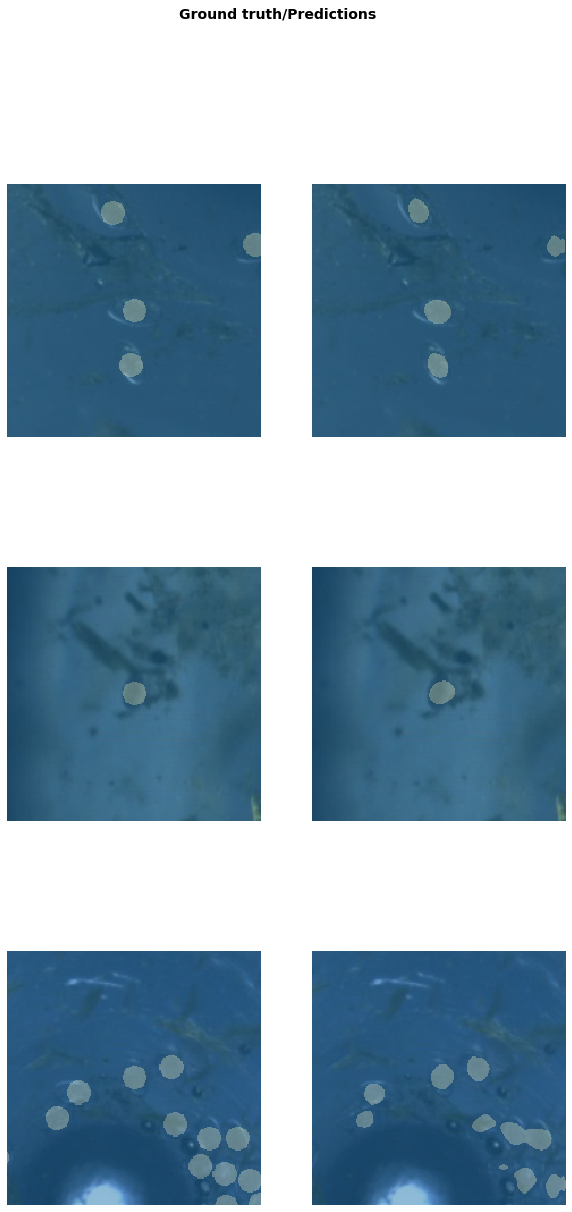

In [15]:
#learn.load("stage1")

#plot results
learn.show_results(rows=3, figsize=(10,20))

In [29]:
# defaults.device = 'cpu'
defaults.device = torch.device("cuda")
defaults.device = torch.device("cpu")

def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()   
## uses torch.nn.CrossEntropyLoss(...)    as a super class  
class myLoss2(nn.CrossEntropyLoss):    
    def __init__(self, weight=None):
        super(myLoss2, self).__init__()

    def forward(self, input, target):
        target = target.squeeze()
        ret = super(myLoss2, self).forward(input, target)
        return ret
    
learn = load_learner('./jn-pickels', 'export-half-espnet-0906.pkl')

learn.model.float()
bs = 20
data = (src.transform(get_transforms(flip_vert=True),  tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn.data = data

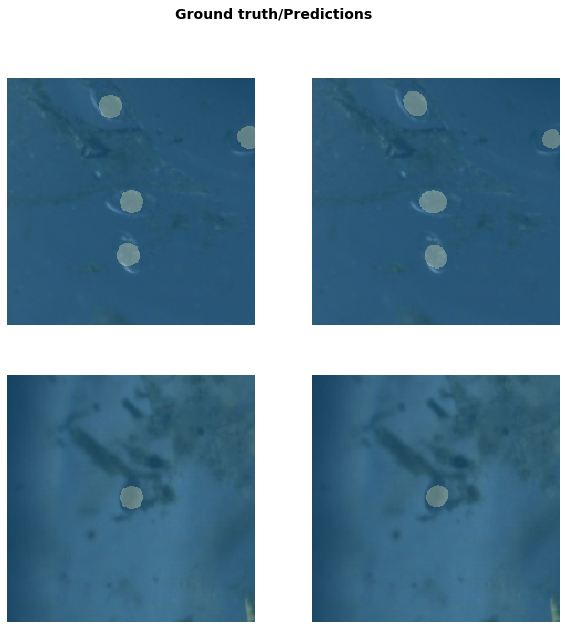

In [11]:
learn.show_results(rows=2, figsize=(10,10), ds_type=DatasetType.Valid)



In [16]:
data = (src.transform(get_transforms(flip_vert=True),  tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn.data = data

2019-09-10 09:53:29.177953
tensor(1)


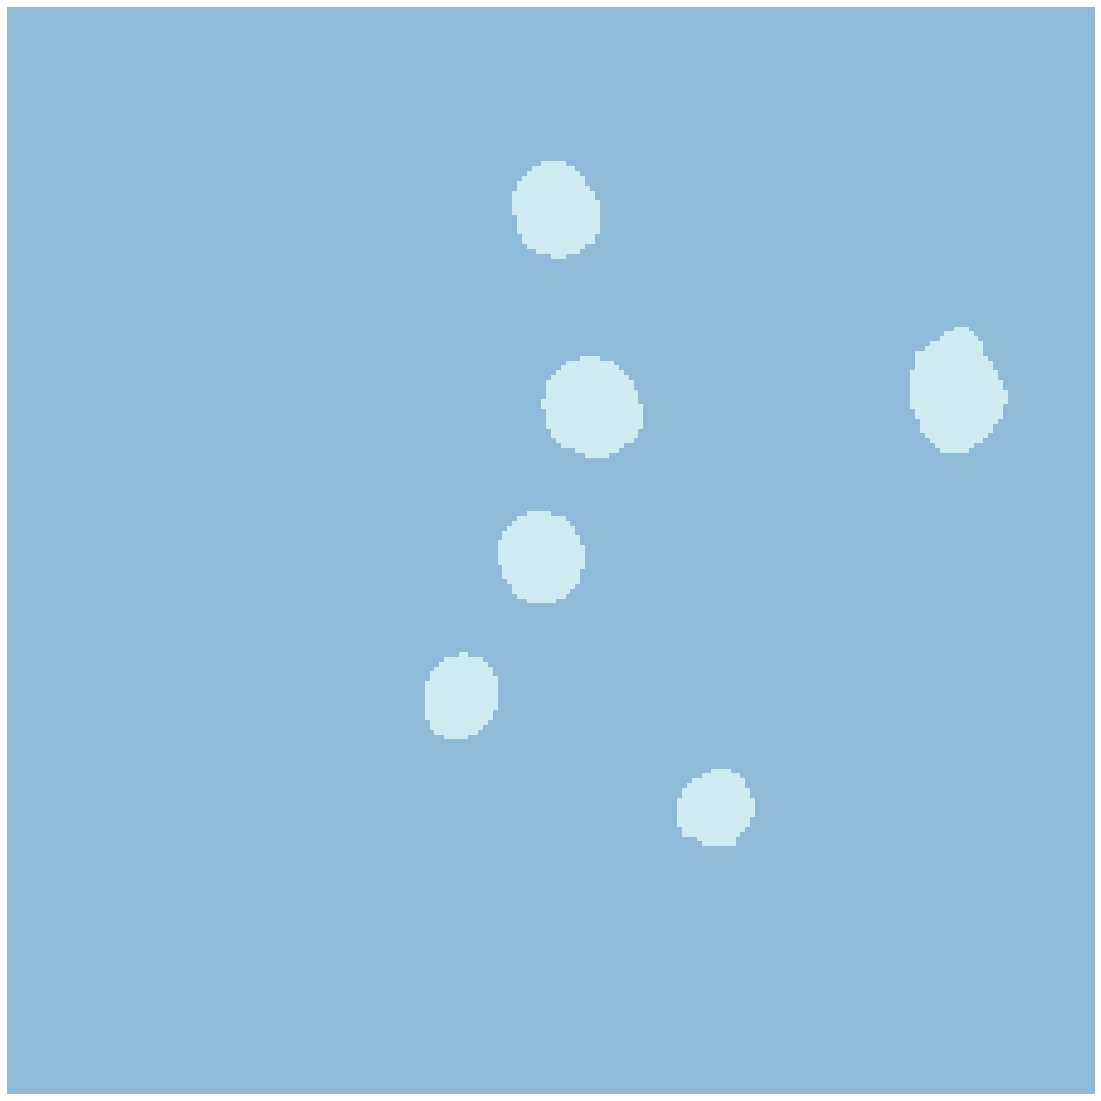

In [22]:
#
from datetime import datetime
# fn = Path('/home/john/github/data/FEC_full_res/crop/images-400/220972 - 2-12.jpg')
fn = Path('/home/john/github/data/FEC-crop-half/images-200-subset/220968 - 1-18.jpg')
# fn = Path('/home/john/github/data/FEC-crop-half/images-200/221457 - 2-6.jpg')
# img = PIL.Image.open(fn).resize((208,208))
# fn = Path('/home/john/github/data/FEC-test/220968 - 2.jpg')
img = PIL.Image.open(fn)
mrk_path = Path('./results-FEC/')  
mrk_path.mkdir(parents=True, exist_ok=True)

# sz = 800
# x,y = 400, 200
# area = (x, y, x+sz, y+sz)
# cropped_img = img.crop(area)
cropped_img = img

img = Image(pil2tensor(cropped_img, np.float32).div_(255))
pad(img, int((14*16-200)/2), 'zeros')

for i in range(1):
    print(datetime.now() )
    pc,pi,o = learn.predict(img)
print(pc.px.max())
pc.show(figsize=(20,20))
# cropped_img.show()
# pred_img = to_np(o).transpose(1,2,0)[:,:,:3]
# PIL.Image.fromarray((pred_img*255).astype(np.uint8)).save(f'{mrk_path}/{fn.stem}.png')  

2019-09-10 09:51:58.419615
tensor(1)


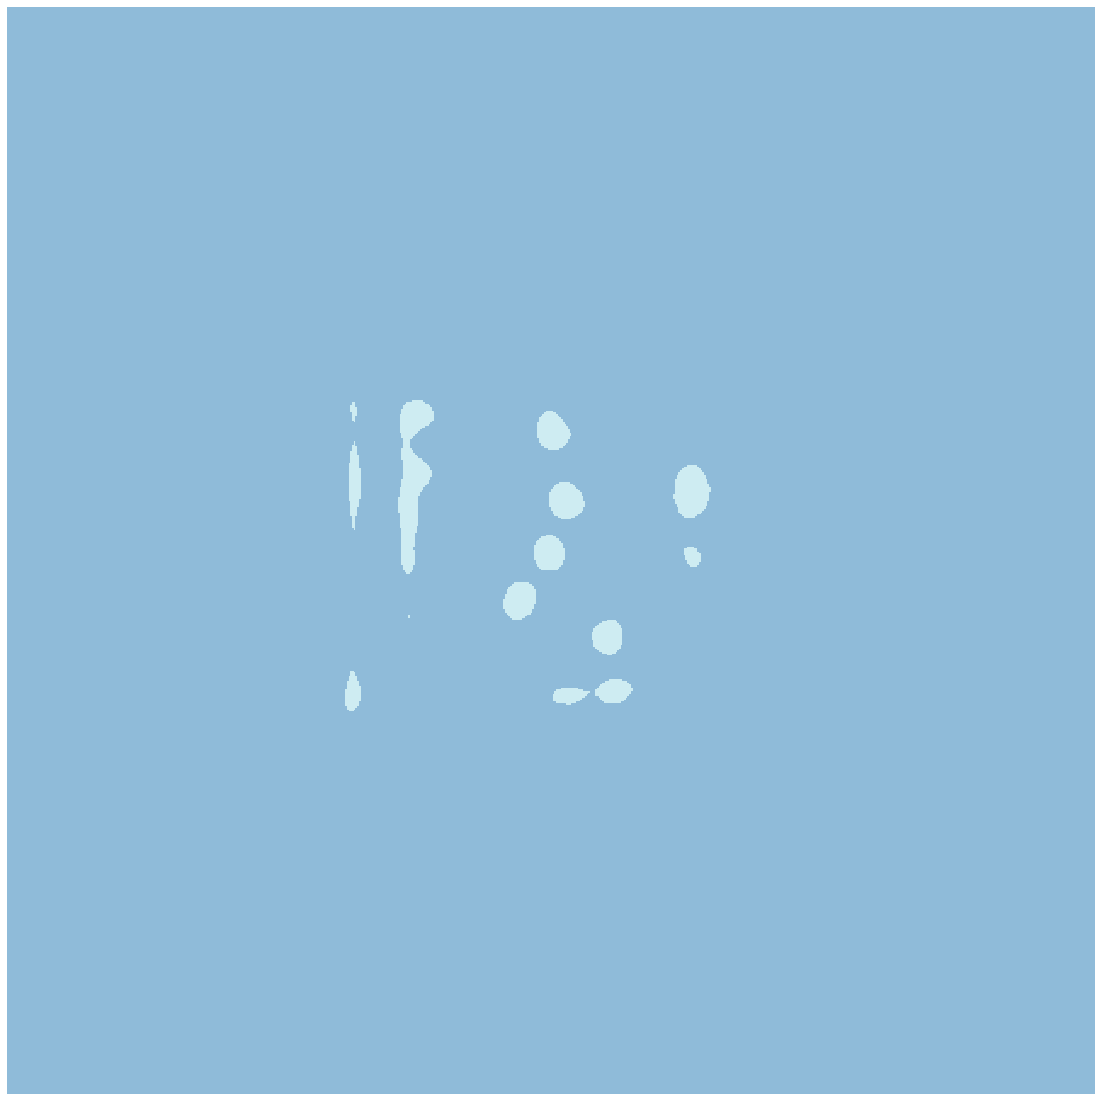

In [20]:
from datetime import datetime
fn = Path('/home/john/github/data/FEC-crop-half/images-200-subset/220968 - 1-18.jpg')

img = PIL.Image.open(fn)
img = Image(pil2tensor(img, np.float32).div_(255))
pad(img, int((40*16-200)/2), 'zeros')

for i in range(1):
    print(datetime.now() )
    pc,pi,o = learn.predict(img)
print(pc.px.max())
pc.show(figsize=(20,20))

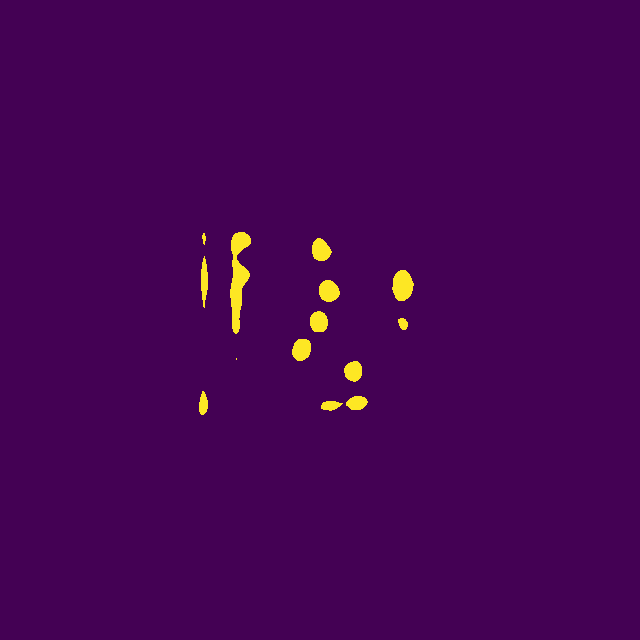

In [21]:
pc

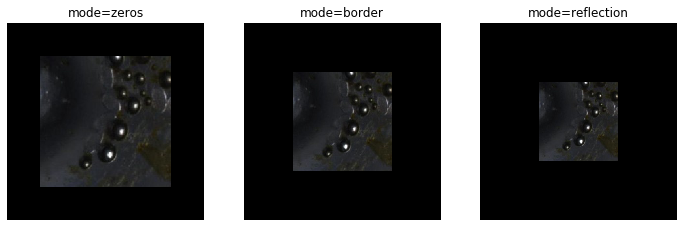

In [12]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
for mode, ax in zip(['zeros', 'border', 'reflection'], axs):
    pad(img, 50, mode).show(ax=ax, title=f'mode={mode}')

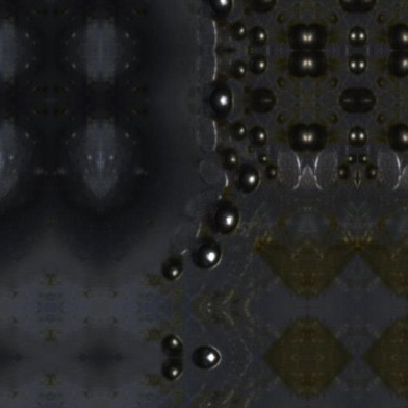

In [35]:
pad(img, 50, 'zeros')

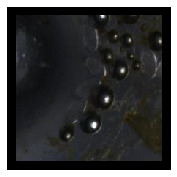

In [23]:
img.show()


In [ ]:
import cv2
from skimage.measure import label, regionprops
from skimage import filters
from skimage.morphology import erosion, dilation, opening, closing, disk
from scipy.spatial import distance
import pandas as pd
from pandas import DataFrame

def find_prediction_blobs(self, img, CONF=0.5, radius=40, plot=False): 
    # region props seems to have region.max_intensity errors if no data not np.int 
    SCALE = 100
    CONF *= SCALE
    selem = disk(6)
#     img = filters.gaussian(img, sigma= 1 / 40, multichannel=True)
    img = (img * (SCALE/img.max())).astype(np.int)
    img[img[:,:,0]<CONF,0] = 0
    img[img[:,:,1]<CONF,1] = 0
#     img[:,:,0] = img[:,:,0] > CONF
#     img[:,:,1] = img[:,:,1] > CONF
    predictions = []
#     imgL = img[:,:,0].astype(np.int)
#     img[:,:,0] = closing(img[:,:,0], selem)
#     img[:,:,1] = closing(img[:,:,1], selem)
#     img[:,:,0] = opening(img[:,:,0], selem)
#     img[:,:,1] = opening(img[:,:,1], selem)

    fill = (255,0,0)
    label_image0 = label(img[:,:,0] > CONF)
    label_image1 = label(img[:,:,1] > CONF)

#         img = img.copy()  # helped with a cv error?
    img = np.array(img) # helped with a cv error?
    for region in regionprops(label_image0, img[:,:,0], cache=True):
        if region.area > 100:
            cx = int(region.centroid[1])
            cy = int(region.centroid[0])
#                 import pdb; pdb.set_trace()
#                 cv2.rectangle(img, (cx - radius, cy - radius), (cx + radius, cy + radius), fill, 5)
            predictions.append({"label": 'Strongyle', "point": [cx,cy], "probability": region.max_intensity.round(2)})  
#             print(' 0:', [cx,cy], 'area:',  region.area, 
#                   'max',  region.max_intensity.round(2), 
#                   'mean', region.mean_intensity.round(2))
    fill = (0,255,0)
    img = np.array(img) # helped with a cv error?
    for region in regionprops(label_image1, img[:,:,1]):
        if region.area > 100:
            cx = int(region.centroid[1])
            cy = int(region.centroid[0])
#                 cv2.rectangle(img, (cx - radius, cy - radius), (cx + radius, cy + radius), fill, 5)
            predictions.append({"label": 'Nematodirus',"point": [cx,cy], "probability": region.max_intensity.round(2)})
#             print(f' 1: area {region.area}, max intensity {region.max_intensity.round(5)}')
#         #     print(region.area)
    if plot:
        #   show_img(imglab, figsize = (15,15))
        plt.figure(figsize=(15, 15))
        plt.subplot(121)
        plt.imshow(label_image0, cmap='nipy_spectral')
        #   plt.imshow(img[:,:,0] > CONF, cmap='nipy_spectral')
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(label_image1, cmap='nipy_spectral')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return predictions, img
def test_find_prediction_blobs(self ): 
#     fn = 'data/markup/220966 - 1.png'
    tst_path = Path('data/test/')
    fn = Path('data/markup/221221 - 1.png')
    print(f"Testing: def test_find_prediction_blobs('{fn}'):")
    img = np.asarray(PIL.Image.open(fn))


    anno_list, proc_img = find_prediction_blobs(img, plot=True)
    print("Max value", proc_img.max())
    PIL.Image.fromarray(proc_img.astype(np.uint8)).save(f'{tst_path}/{fn.stem}.png') 
#     print(anno_list)

In [ ]:
img_path = Path('data/images-half/')
mrk_path = Path('data/images-half-markup/')  
mrk_path.mkdir(parents=True, exist_ok=True)